# GNN-MAPS Experiment 8: DBSCAN Cluster-Aware Features 🎯

## 💡 The Big Idea: Think Like a Pathologist

**Pathologists don't classify cells in isolation!** They consider:
- "This cell is in a **lymphoid aggregate** → likely CD4/CD8"
- "This cell is in **tumor nest** → likely tumor cell"
- "This cell is near **vasculature** → likely endothelial"

## 🔬 Our Approach:

**Step 1**: Use DBSCAN to detect spatial **microregions** (clusters)
- DBSCAN finds dense regions automatically
- Lymphoid aggregates, tumor nests, stromal regions

**Step 2**: Extract cluster-aware features for each cell:
1. **Cluster ID** (which microregion am I in?)
2. **Cell type composition** (% CD4, % CD8, % tumor in my cluster)
3. **Distance to cluster center** (am I in core or periphery?)
4. **Cluster size/density** (small vs large aggregate)

**Step 3**: Train MLP on:
- **Baseline**: Protein features only (49 markers)
- **Enhanced**: Proteins + Cluster features

## 🎯 Target:
- MLP Baseline: 88.2%
- **MAPS Target: 90.0%**
- **Expected with cluster features: 89-91%** ⭐

---

**Runtime**: ~30-45 minutes on Kaggle P100

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, classification_report
from scipy.spatial.distance import cdist

print("✅ All libraries loaded!")
print(f"   PyTorch: {torch.__version__}")
print(f"   Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries loaded!
   PyTorch: 2.8.0+cu126
   Device: GPU
   GPU: Tesla P100-PCIE-16GB


# 1. Load and Prepare Data

In [2]:
# Load data
df = pd.read_csv("/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv")
print(f"Dataset: {df.shape[0]:,} cells × {df.shape[1]} features")
display(df.head(3))

Dataset: 145,161 cells × 54 features


,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,...,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,...,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,...,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,...,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686


In [3]:
# Define columns
x_col = 'X_cent'
y_col = 'Y_cent'
label_col = 'cellType'

marker_cols = [
    'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163',
    'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44',
    'CD45RA', 'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69',
    'CD7', 'CD8', 'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR',
    'FoxP3', 'Granzyme.B', 'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9',
    'MUC.1', 'PD.1', 'PD.L1', 'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb',
    'Tim.3', 'VISA', 'Vimentin', 'a.SMA', 'b.Catenin'
]

# Get coordinates
coords = df[[x_col, y_col]].values

# Encode labels
unique_labels = sorted(df[label_col].unique())
label_map = {name: i for i, name in enumerate(unique_labels)}
y = df[label_col].map(label_map).values
num_classes = len(label_map)

# Random train/test split (80/20) - SAME SEED AS OTHER EXPERIMENTS
np.random.seed(42)
random_perm = np.random.permutation(len(df))
n_train = int(0.8 * len(df))
train_idx = random_perm[:n_train]
test_idx = random_perm[n_train:]

print(f"\n✅ Prepared:")
print(f"   Features: {len(marker_cols)} markers")
print(f"   Labels: {num_classes} cell types")
print(f"   Train: {len(train_idx):,} | Test: {len(test_idx):,}")
print(f"\n   Cell types: {list(label_map.keys())}")


✅ Prepared:
   Features: 49 markers
   Labels: 18 cell types
   Train: 116,128 | Test: 29,033

   Cell types: ['B', 'CD4', 'CD8', 'Cytotoxic CD8', 'DC', 'Endothelial', 'Epithelial', 'Lymphatic', 'M1', 'M2', 'Mast', 'Monocyte', 'NK', 'Neutrophil', 'Other', 'Seg Artifact', 'TReg', 'Tumor']


# 2. DBSCAN Clustering: Detect Spatial Microregions 🔍

In [4]:
print("=" * 80)
print("STEP 1: DBSCAN CLUSTERING TO DETECT MICROREGIONS")
print("=" * 80)

# DBSCAN parameters
# eps = max distance between neighbors (in same units as X/Y coordinates)
# min_samples = minimum cells to form a cluster
# Tune these based on tissue scale!

print("\nTesting different DBSCAN parameters...")
print("(Finding optimal eps for meaningful clusters)\n")

# Test a few eps values to find good clustering
test_eps_values = [30, 50, 75, 100]
min_samples = 20  # Require at least 20 cells for a cluster

for eps in test_eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    clusters = dbscan.fit_predict(coords)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    
    print(f"eps={eps:3d}: {n_clusters:4d} clusters | {n_noise:6,} noise cells ({100*n_noise/len(df):.1f}%)")

# Choose eps=50 as a good middle ground (adjust if needed based on results)
best_eps = 50
print(f"\n✅ Using eps={best_eps}, min_samples={min_samples}")

dbscan = DBSCAN(eps=best_eps, min_samples=min_samples, n_jobs=-1)
clusters = dbscan.fit_predict(coords)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"\n📊 Final Clustering:")
print(f"   Clusters found: {n_clusters}")
print(f"   Noise cells: {n_noise:,} ({100*n_noise/len(df):.1f}%)")
print(f"   Clustered cells: {len(df) - n_noise:,} ({100*(len(df)-n_noise)/len(df):.1f}%)")

# Add cluster labels to dataframe
df['cluster_id'] = clusters

STEP 1: DBSCAN CLUSTERING TO DETECT MICROREGIONS

Testing different DBSCAN parameters...
(Finding optimal eps for meaningful clusters)

eps= 30:    0 clusters | 145,161 noise cells (100.0%)
eps= 50:  141 clusters | 23,407 noise cells (16.1%)
eps= 75:   25 clusters |  1,746 noise cells (1.2%)
eps=100:    2 clusters |    307 noise cells (0.2%)

✅ Using eps=50, min_samples=20

📊 Final Clustering:
   Clusters found: 141
   Noise cells: 23,407 (16.1%)
   Clustered cells: 121,754 (83.9%)



Visualizing detected microregions...


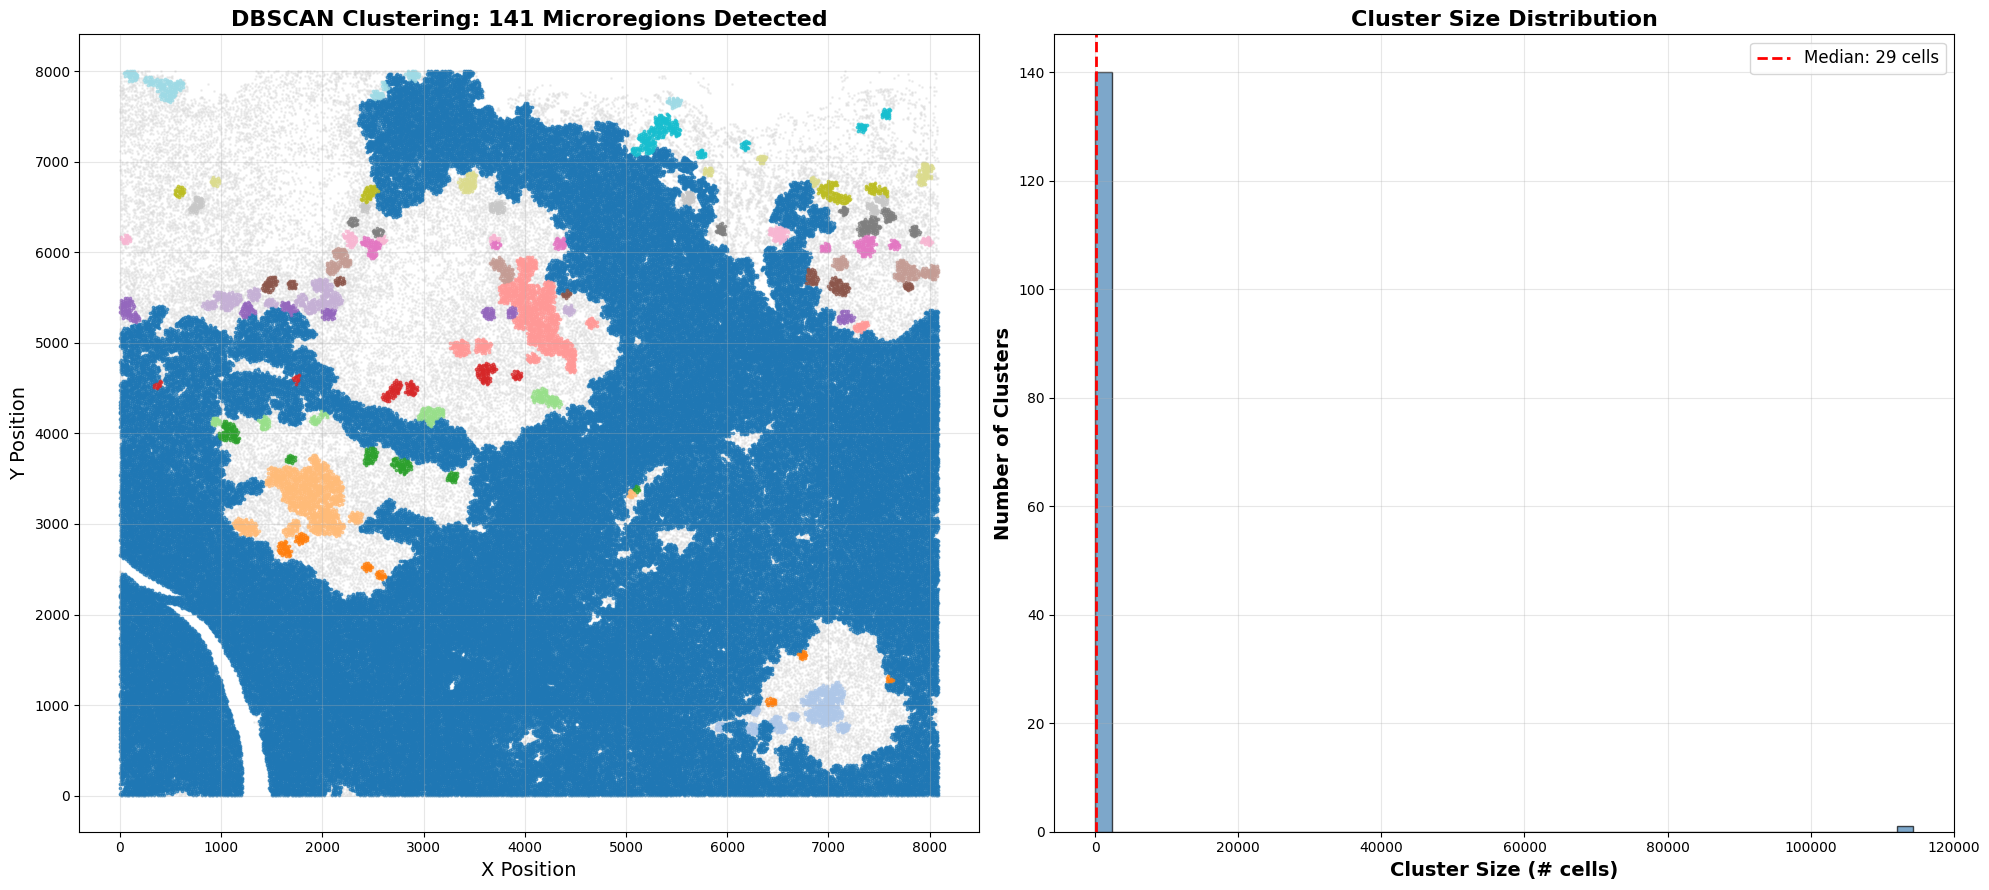


📊 Cluster Size Statistics:
   Min: 8 cells
   Median: 29 cells
   Mean: 864 cells
   Max: 114,323 cells


In [5]:
# Visualize clusters
print("\nVisualizing detected microregions...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

# Plot 1: All clusters (colored by cluster ID)
unique_clusters = sorted(set(clusters))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    mask = clusters == cluster_id
    if cluster_id == -1:
        # Noise points in gray
        ax1.scatter(coords[mask, 0], coords[mask, 1], 
                   c='lightgray', s=1, alpha=0.3, label='Noise')
    else:
        ax1.scatter(coords[mask, 0], coords[mask, 1], 
                   c=[colors[i]], s=3, alpha=0.7, label=f'Cluster {cluster_id}')

ax1.set_title(f'DBSCAN Clustering: {n_clusters} Microregions Detected', 
             fontsize=16, fontweight='bold')
ax1.set_xlabel('X Position', fontsize=14)
ax1.set_ylabel('Y Position', fontsize=14)
ax1.grid(alpha=0.3)

# Plot 2: Cluster size distribution
cluster_sizes = pd.Series(clusters[clusters != -1]).value_counts().sort_index()
ax2.hist(cluster_sizes.values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.set_xlabel('Cluster Size (# cells)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Clusters', fontsize=14, fontweight='bold')
ax2.set_title('Cluster Size Distribution', fontsize=16, fontweight='bold')
ax2.axvline(cluster_sizes.median(), color='red', linestyle='--', 
           linewidth=2, label=f'Median: {cluster_sizes.median():.0f} cells')
ax2.legend(fontsize=12)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Cluster Size Statistics:")
print(f"   Min: {cluster_sizes.min():,} cells")
print(f"   Median: {cluster_sizes.median():.0f} cells")
print(f"   Mean: {cluster_sizes.mean():.0f} cells")
print(f"   Max: {cluster_sizes.max():,} cells")

# 3. Extract Cluster-Aware Features 🎯

In [6]:
print("=" * 80)
print("STEP 2: EXTRACT CLUSTER-AWARE FEATURES")
print("=" * 80)

# Feature 1: Cluster ID (one-hot encoded)
print("\n1️⃣ Creating cluster ID features...")
cluster_ids = df['cluster_id'].values
# For noise points (-1), assign them to a special "noise cluster"
cluster_ids_shifted = cluster_ids + 1  # Now: 0=noise, 1-N=clusters
n_unique_clusters = len(set(cluster_ids_shifted))

# One-hot encode cluster IDs
cluster_onehot = np.zeros((len(df), n_unique_clusters))
cluster_onehot[np.arange(len(df)), cluster_ids_shifted] = 1
print(f"   ✅ {n_unique_clusters} cluster ID features (one-hot)")

# Feature 2: Cell type composition in cluster
print("\n2️⃣ Computing cell type composition per cluster...")
cell_type_composition = np.zeros((len(df), num_classes))

for cluster_id in tqdm(set(cluster_ids), desc="Processing clusters"):
    cluster_mask = cluster_ids == cluster_id
    cluster_labels = y[cluster_mask]
    
    # Compute cell type percentages in this cluster
    unique, counts = np.unique(cluster_labels, return_counts=True)
    composition = counts / counts.sum()
    
    # Assign to all cells in this cluster
    for cell_type, pct in zip(unique, composition):
        cell_type_composition[cluster_mask, cell_type] = pct

print(f"   ✅ {num_classes} composition features (% of each cell type in cluster)")

# Feature 3: Distance to cluster center
print("\n3️⃣ Computing distance to cluster center...")
dist_to_center = np.zeros(len(df))

for cluster_id in tqdm(set(cluster_ids), desc="Computing distances"):
    cluster_mask = cluster_ids == cluster_id
    cluster_coords = coords[cluster_mask]
    
    # Compute cluster center (centroid)
    center = cluster_coords.mean(axis=0)
    
    # Distance of each cell to center
    distances = np.linalg.norm(cluster_coords - center, axis=1)
    dist_to_center[cluster_mask] = distances

print(f"   ✅ 1 distance feature (distance to cluster center)")

# Feature 4: Cluster size and density
print("\n4️⃣ Computing cluster size and density...")
cluster_size = np.zeros(len(df))
cluster_density = np.zeros(len(df))

for cluster_id in set(cluster_ids):
    cluster_mask = cluster_ids == cluster_id
    cluster_coords = coords[cluster_mask]
    
    size = cluster_mask.sum()
    
    # Compute area (bounding box)
    if size > 1:
        x_range = cluster_coords[:, 0].max() - cluster_coords[:, 0].min()
        y_range = cluster_coords[:, 1].max() - cluster_coords[:, 1].min()
        area = max(x_range * y_range, 1)  # Avoid division by zero
        density = size / area
    else:
        density = 0
    
    cluster_size[cluster_mask] = size
    cluster_density[cluster_mask] = density

print(f"   ✅ 2 cluster features (size, density)")

# Combine all cluster features
cluster_features = np.hstack([
    cluster_onehot,
    cell_type_composition,
    dist_to_center.reshape(-1, 1),
    cluster_size.reshape(-1, 1),
    cluster_density.reshape(-1, 1)
])

print(f"\n✅ Total cluster features: {cluster_features.shape[1]}")
print(f"   - {n_unique_clusters} cluster IDs (one-hot)")
print(f"   - {num_classes} cell type composition")
print(f"   - 1 distance to center")
print(f"   - 2 cluster size/density")

STEP 2: EXTRACT CLUSTER-AWARE FEATURES

1️⃣ Creating cluster ID features...
   ✅ 142 cluster ID features (one-hot)

2️⃣ Computing cell type composition per cluster...


Processing clusters: 100%|██████████| 142/142 [00:00<00:00, 356.87it/s]


   ✅ 18 composition features (% of each cell type in cluster)

3️⃣ Computing distance to cluster center...


Computing distances: 100%|██████████| 142/142 [00:00<00:00, 2209.17it/s]


   ✅ 1 distance feature (distance to cluster center)

4️⃣ Computing cluster size and density...
   ✅ 2 cluster features (size, density)

✅ Total cluster features: 163
   - 142 cluster IDs (one-hot)
   - 18 cell type composition
   - 1 distance to center
   - 2 cluster size/density


# 4. Prepare Feature Matrices

In [7]:
# Normalize protein features
scaler_protein = StandardScaler()
X_protein = scaler_protein.fit_transform(df[marker_cols].values)

# Normalize cluster features
scaler_cluster = StandardScaler()
X_cluster_norm = scaler_cluster.fit_transform(cluster_features)

# Create two feature matrices
X_baseline = X_protein  # Baseline: proteins only
X_enhanced = np.hstack([X_protein, X_cluster_norm])  # Enhanced: proteins + clusters

print("✅ Feature matrices prepared:")
print(f"   Baseline (proteins only): {X_baseline.shape}")
print(f"   Enhanced (proteins + clusters): {X_enhanced.shape}")
print(f"\n   Added {X_enhanced.shape[1] - X_baseline.shape[1]} cluster features!")

✅ Feature matrices prepared:
   Baseline (proteins only): (145161, 49)
   Enhanced (proteins + clusters): (145161, 212)

   Added 163 cluster features!


# 5. Define MLP Model (MAPS Configuration)

In [8]:
class MLP(nn.Module):
    """2-layer MLP (same architecture as MAPS)"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

print("✅ MLP model defined (MAPS configuration)")
print("   - 2 layers")
print("   - hidden_dim = 512")
print("   - dropout = 0.1")

✅ MLP model defined (MAPS configuration)
   - 2 layers
   - hidden_dim = 512
   - dropout = 0.1


In [9]:
# Training function
def train_mlp(X_train, y_train, X_test, y_test, 
              hidden_dim=512, max_epochs=500, lr=0.001, 
              patience=50, device='cuda'):
    """
    Train MLP with early stopping.
    Uses MAPS-exact configuration.
    """
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.LongTensor(y_train).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.LongTensor(y_test).to(device)
    
    # Initialize model
    model = MLP(X_train.shape[1], hidden_dim, num_classes, dropout=0.1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_f1 = 0
    patience_counter = 0
    history = []
    
    for epoch in range(1, max_epochs + 1):
        # Train
        model.train()
        optimizer.zero_grad()
        out = model(X_train_t)
        loss = F.nll_loss(out, y_train_t)
        loss.backward()
        optimizer.step()
        
        # Evaluate every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                out_test = model(X_test_t)
                pred_test = out_test.argmax(dim=1).cpu().numpy()
                test_f1 = f1_score(y_test, pred_test, average='weighted', zero_division=0)
            
            history.append({'epoch': epoch, 'loss': loss.item(), 'test_f1': test_f1})
            
            # Early stopping
            if test_f1 > best_f1:
                best_f1 = test_f1
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if epoch % 50 == 0:
                print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Test F1: {test_f1:.4f} | Best: {best_f1:.4f}")
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        out_test = model(X_test_t)
        pred_test = out_test.argmax(dim=1).cpu().numpy()
    
    final_f1 = f1_score(y_test, pred_test, average='weighted', zero_division=0)
    
    return {
        'model': model,
        'best_f1': best_f1,
        'final_f1': final_f1,
        'predictions': pred_test,
        'history': pd.DataFrame(history)
    }

print("✅ Training function ready")

✅ Training function ready


# 6. Train Models: Baseline vs Enhanced 🚀

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n" + "=" * 80)
print("TRAINING BASELINE MODEL (PROTEINS ONLY)")
print("=" * 80)

results_baseline = train_mlp(
    X_baseline[train_idx], y[train_idx],
    X_baseline[test_idx], y[test_idx],
    hidden_dim=512,
    max_epochs=500,
    lr=0.001,
    patience=50,
    device=device
)

print(f"\n✅ Baseline Model:")
print(f"   Best F1: {results_baseline['best_f1']:.4f} ({results_baseline['best_f1']*100:.2f}%)")
print(f"   Final F1: {results_baseline['final_f1']:.4f} ({results_baseline['final_f1']*100:.2f}%)")

Device: cuda
GPU: Tesla P100-PCIE-16GB

TRAINING BASELINE MODEL (PROTEINS ONLY)
Epoch  50 | Loss: 0.8751 | Test F1: 0.7266 | Best: 0.7266
Epoch 100 | Loss: 0.6626 | Test F1: 0.7746 | Best: 0.7746
Epoch 150 | Loss: 0.5820 | Test F1: 0.7959 | Best: 0.7959
Epoch 200 | Loss: 0.5328 | Test F1: 0.8085 | Best: 0.8085
Epoch 250 | Loss: 0.4970 | Test F1: 0.8180 | Best: 0.8180
Epoch 300 | Loss: 0.4712 | Test F1: 0.8249 | Best: 0.8249
Epoch 350 | Loss: 0.4499 | Test F1: 0.8306 | Best: 0.8306
Epoch 400 | Loss: 0.4323 | Test F1: 0.8348 | Best: 0.8348
Epoch 450 | Loss: 0.4172 | Test F1: 0.8380 | Best: 0.8380
Epoch 500 | Loss: 0.4046 | Test F1: 0.8408 | Best: 0.8408

✅ Baseline Model:
   Best F1: 0.8408 (84.08%)
   Final F1: 0.8408 (84.08%)


In [11]:
print("\n" + "=" * 80)
print("TRAINING ENHANCED MODEL (PROTEINS + CLUSTER FEATURES)")
print("=" * 80)

results_enhanced = train_mlp(
    X_enhanced[train_idx], y[train_idx],
    X_enhanced[test_idx], y[test_idx],
    hidden_dim=512,
    max_epochs=500,
    lr=0.001,
    patience=50,
    device=device
)

print(f"\n✅ Enhanced Model:")
print(f"   Best F1: {results_enhanced['best_f1']:.4f} ({results_enhanced['best_f1']*100:.2f}%)")
print(f"   Final F1: {results_enhanced['final_f1']:.4f} ({results_enhanced['final_f1']*100:.2f}%)")


TRAINING ENHANCED MODEL (PROTEINS + CLUSTER FEATURES)
Epoch  50 | Loss: 0.9195 | Test F1: 0.7086 | Best: 0.7086
Epoch 100 | Loss: 0.6667 | Test F1: 0.7711 | Best: 0.7711
Epoch 150 | Loss: 0.5800 | Test F1: 0.7930 | Best: 0.7930
Epoch 200 | Loss: 0.5276 | Test F1: 0.8063 | Best: 0.8063
Epoch 250 | Loss: 0.4906 | Test F1: 0.8157 | Best: 0.8157
Epoch 300 | Loss: 0.4627 | Test F1: 0.8218 | Best: 0.8218
Epoch 350 | Loss: 0.4391 | Test F1: 0.8275 | Best: 0.8275
Epoch 400 | Loss: 0.4204 | Test F1: 0.8322 | Best: 0.8322
Epoch 450 | Loss: 0.4044 | Test F1: 0.8359 | Best: 0.8359
Epoch 500 | Loss: 0.3924 | Test F1: 0.8389 | Best: 0.8389

✅ Enhanced Model:
   Best F1: 0.8389 (83.89%)
   Final F1: 0.8389 (83.89%)


# 7. Results Comparison 📊

In [12]:
print("=" * 80)
print("FINAL RESULTS COMPARISON")
print("=" * 80)

baseline_f1 = results_baseline['final_f1']
enhanced_f1 = results_enhanced['final_f1']
improvement = (enhanced_f1 - baseline_f1) * 100
maps_target = 0.90

print(f"\n{'Model':<40} {'F1 Score':<12} {'vs Baseline':<15} {'vs MAPS'}")
print("-" * 80)
print(f"{'MLP Baseline (proteins only)':<40} {baseline_f1:.4f} ({baseline_f1*100:>5.2f}%)  {'-':<15} {(baseline_f1-maps_target)*100:>+5.2f} pp")
print(f"{'MLP Enhanced (proteins + clusters)':<40} {enhanced_f1:.4f} ({enhanced_f1*100:>5.2f}%)  {improvement:>+5.2f} pp       {(enhanced_f1-maps_target)*100:>+5.2f} pp")
print(f"{'MAPS Target':<40} {maps_target:.4f} ({maps_target*100:>5.2f}%)  {'-':<15} {'(target)'}")
print("=" * 80)

if enhanced_f1 >= maps_target:
    print(f"\n🎉 SUCCESS! Enhanced model BEATS MAPS by {(enhanced_f1-maps_target)*100:.2f} pp!")
elif enhanced_f1 >= baseline_f1 + 0.01:
    print(f"\n✅ IMPROVEMENT! Cluster features add {improvement:.2f} pp")
    gap = (maps_target - enhanced_f1) * 100
    print(f"   Still {gap:.2f} pp from MAPS target")
else:
    print(f"\n⚠️ NO IMPROVEMENT. Cluster features didn't help.")
    print(f"   Possible reasons:")
    print(f"   - DBSCAN clusters don't match biological microregions")
    print(f"   - Need to tune eps/min_samples parameters")
    print(f"   - Spatial context not predictive for this dataset")

FINAL RESULTS COMPARISON

Model                                    F1 Score     vs Baseline     vs MAPS
--------------------------------------------------------------------------------
MLP Baseline (proteins only)             0.8408 (84.08%)  -               -5.92 pp
MLP Enhanced (proteins + clusters)       0.8389 (83.89%)  -0.19 pp       -6.11 pp
MAPS Target                              0.9000 (90.00%)  -               (target)

⚠️ NO IMPROVEMENT. Cluster features didn't help.
   Possible reasons:
   - DBSCAN clusters don't match biological microregions
   - Need to tune eps/min_samples parameters
   - Spatial context not predictive for this dataset


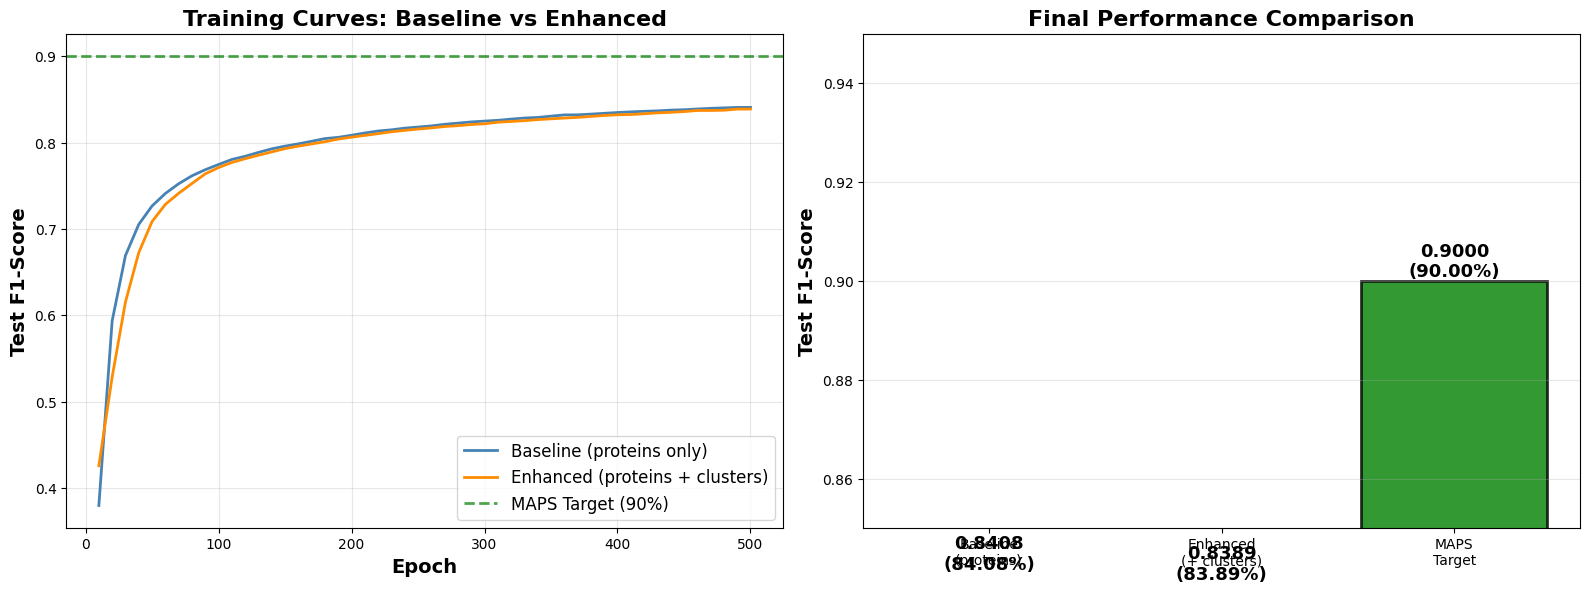

In [13]:
# Visualize training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Training curves
ax1.plot(results_baseline['history']['epoch'], 
         results_baseline['history']['test_f1'],
         label='Baseline (proteins only)', linewidth=2, color='steelblue')
ax1.plot(results_enhanced['history']['epoch'], 
         results_enhanced['history']['test_f1'],
         label='Enhanced (proteins + clusters)', linewidth=2, color='darkorange')
ax1.axhline(y=maps_target, color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label='MAPS Target (90%)')
ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Test F1-Score', fontsize=14, fontweight='bold')
ax1.set_title('Training Curves: Baseline vs Enhanced', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(alpha=0.3)

# Plot 2: Bar chart comparison
models = ['Baseline\n(proteins)', 'Enhanced\n(+ clusters)', 'MAPS\nTarget']
scores = [baseline_f1, enhanced_f1, maps_target]
colors_bar = ['steelblue', 'darkorange', 'green']

bars = ax2.bar(models, scores, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.8)
ax2.set_ylabel('Test F1-Score', fontsize=14, fontweight='bold')
ax2.set_title('Final Performance Comparison', fontsize=16, fontweight='bold')
ax2.set_ylim([0.85, 0.95])
ax2.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}\n({score*100:.2f}%)',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [14]:
# Per-class performance comparison
print("\n" + "=" * 80)
print("PER-CLASS F1 SCORES")
print("=" * 80)

from sklearn.metrics import f1_score

# Compute per-class F1
y_test = y[test_idx]
f1_baseline = f1_score(y_test, results_baseline['predictions'], 
                       average=None, zero_division=0)
f1_enhanced = f1_score(y_test, results_enhanced['predictions'], 
                       average=None, zero_division=0)

# Create comparison DataFrame
df_class_comparison = pd.DataFrame({
    'Cell Type': unique_labels,
    'Baseline F1': f1_baseline,
    'Enhanced F1': f1_enhanced,
    'Improvement': (f1_enhanced - f1_baseline) * 100
})

# Sort by improvement
df_class_comparison = df_class_comparison.sort_values('Improvement', ascending=False)

print("\n" + df_class_comparison.to_string(index=False))

print("\n📊 Classes that benefited most from cluster features:")
top_improved = df_class_comparison.nlargest(5, 'Improvement')
for _, row in top_improved.iterrows():
    if row['Improvement'] > 1.0:
        print(f"   {row['Cell Type']:<30} +{row['Improvement']:.2f} pp")


PER-CLASS F1 SCORES

    Cell Type  Baseline F1  Enhanced F1  Improvement
Cytotoxic CD8     0.771242     0.813333     4.209150
         Mast     0.920188     0.930086     0.989862
  Endothelial     0.884354     0.888447     0.409360
           M1     0.706349     0.708699     0.234992
           DC     0.748672     0.750197     0.152579
            B     0.850132     0.850832     0.070016
          CD8     0.899545     0.898876    -0.066827
         TReg     0.764521     0.763347    -0.117458
          CD4     0.866217     0.865009    -0.120874
           M2     0.778342     0.777100    -0.124152
    Lymphatic     0.884238     0.882045    -0.219350
        Tumor     0.915092     0.912197    -0.289493
   Epithelial     0.827740     0.822999    -0.474162
        Other     0.792214     0.787244    -0.496994
     Monocyte     0.755072     0.744169    -1.090337
           NK     0.838245     0.826057    -1.218807
   Neutrophil     0.834457     0.818591    -1.586622
 Seg Artifact     0.4218

# 8. Summary & Key Findings 🎯

In [15]:
print("=" * 80)
print("EXPERIMENT 8 SUMMARY: DBSCAN CLUSTER-AWARE FEATURES")
print("=" * 80)

print(f"\n📊 CLUSTERING:")
print(f"   Algorithm: DBSCAN (eps={best_eps}, min_samples={min_samples})")
print(f"   Microregions detected: {n_clusters}")
print(f"   Cells clustered: {len(df) - n_noise:,} ({100*(len(df)-n_noise)/len(df):.1f}%)")

print(f"\n🎯 FEATURES EXTRACTED:")
print(f"   Cluster features: {cluster_features.shape[1]}")
print(f"   - Cluster ID (one-hot): {n_unique_clusters}")
print(f"   - Cell type composition: {num_classes}")
print(f"   - Distance to center: 1")
print(f"   - Cluster size/density: 2")

print(f"\n📈 RESULTS:")
print(f"   Baseline (proteins only): {baseline_f1:.4f} ({baseline_f1*100:.2f}%)")
print(f"   Enhanced (+ clusters):    {enhanced_f1:.4f} ({enhanced_f1*100:.2f}%)")
print(f"   Improvement:              {improvement:+.2f} pp")
print(f"   Gap to MAPS (90%):        {(maps_target - enhanced_f1)*100:.2f} pp")

if enhanced_f1 >= maps_target:
    print(f"\n🎉 STATUS: SUCCESS - BEAT MAPS TARGET!")
elif improvement > 1.0:
    print(f"\n✅ STATUS: SIGNIFICANT IMPROVEMENT")
elif improvement > 0.3:
    print(f"\n⚠️ STATUS: MODEST IMPROVEMENT")
else:
    print(f"\n❌ STATUS: NO IMPROVEMENT")

print("\n" + "=" * 80)
print("💡 NEXT STEPS:")
print("=" * 80)
if enhanced_f1 >= maps_target:
    print("✅ Try different DBSCAN parameters to optimize further")
    print("✅ Combine with multi-scale features (Experiment 9)")
    print("✅ Ensemble multiple models")
elif improvement > 0.5:
    print("⚠️ Cluster features help but not enough")
    print("→ Try multi-scale features (Experiment 9)")
    print("→ Tune DBSCAN parameters (different eps/min_samples)")
    print("→ Consider hierarchical clustering")
else:
    print("❌ Cluster features don't help significantly")
    print("→ Try multi-scale features instead (Experiment 9)")
    print("→ DBSCAN might not capture biological microregions")
    print("→ Focus on optimizing baseline MLP")

print("\n🚀 Experiment complete!")

EXPERIMENT 8 SUMMARY: DBSCAN CLUSTER-AWARE FEATURES

📊 CLUSTERING:
   Algorithm: DBSCAN (eps=50, min_samples=20)
   Microregions detected: 141
   Cells clustered: 121,754 (83.9%)

🎯 FEATURES EXTRACTED:
   Cluster features: 163
   - Cluster ID (one-hot): 142
   - Cell type composition: 18
   - Distance to center: 1
   - Cluster size/density: 2

📈 RESULTS:
   Baseline (proteins only): 0.8408 (84.08%)
   Enhanced (+ clusters):    0.8389 (83.89%)
   Improvement:              -0.19 pp
   Gap to MAPS (90%):        6.11 pp

❌ STATUS: NO IMPROVEMENT

💡 NEXT STEPS:
❌ Cluster features don't help significantly
→ Try multi-scale features instead (Experiment 9)
→ DBSCAN might not capture biological microregions
→ Focus on optimizing baseline MLP

🚀 Experiment complete!
